In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import healpy as hp

## How frequently in each night are we observing?

We see that sometimes we observe parts of the sky more than twice in a night. How often does this happen? What is the source? 

We expect to observe some fraction of the sky more than twice per night simply due to field overlaps -- and the more efficiently/contiguously you observe the sky, the larger this amount of 'field overlaps' will be. 
But it's also possible that sometimes the scheduler is re-scheduling pointings for additional visits in each night, so how often is that occuring? 

Some spot-checks of "how often is the scheduler revisiting pointings each night" is possible simply by looking at the sqlite file: a query like

```sqlite> select night, count(distinct(fieldDec)) as npointings, count(fieldDec) as nvisits, (count(fieldDec) - count(distinct(fieldDec))*2) as 'nvisits-npointings*2', (count(fieldDec) - count(distinct(fieldDec))*2)/(1.0*count(distinct(fieldDec))) from summaryallprops where night>59 and night<100 and note like "blob%" group by night;```

will show how many different pointings (npointings) were scheduled (count(distinct(fieldDec)) works for this, as even though the tesselation is dithered from night to night it stays constant within a night), and how many visits occured (count(fieldDec)) (nvisits).

If each pointing is observed twice (as a pair), then nvisits\*2 would equal npointings. Unpaired visits will result in more pointings than nvisits\*2 (negative values for nvisits-npointings\*2). More than two pointings per visit will result in more visits than npointings\*2 (positive values for nvisits-npointings\*2). Running the query above on the baseline (v1.7) gives results ranging from 0 to ~100 .. corresponding to between 0 and 50% re-scheduled visits. However, on the whole, a quick by-eye estimate of the fraction of pointings which are revisited in a night looks like about 10%. BUT, this is only for one small part of the survey, and doesn't include the effect of field overlaps. 

We can also investigate this problem with MAF, using the healpix slicers. We can calculate the number of visits per night, per healpix point, using the `NvisitsPerNightMetric`. This metric returns a *histogram* of the number of visits per night at that point -- if the histogram bins are set to \[1, 2, 3, 4 ..\] then the metric will calculate how many nights get 1 visits, 2 visits, 3 visits, etc. and return this histogram -- at that healpix point. The metric results are then a series of histograms .. we can combine these histograms over the sky (adding up the values in each bin, taking the mean in each bin, etc.) or pull out the value in one of the bins and plotting that for each point in the sky (resulting in a plot of the number of nights with 2 visits per night over the healpix grid, for example). 

By default, the healpix slicer uses a radius for the field of view of 1.75 degrees, the actual Rubin FOV. This radius is used to match the healpix grid points against the opsim pointings (in a kd-tree). This radius is a simple circle and 1.75 degrees reflects the approximate inscribed-circle-fov and is appropriate for most metrics. It will include field overlaps, approximately. Because our metric is calculated on a *per night* basis, the dithering won't affect the metric results -- only the field overlaps or field re-visits will be included.

However, we can also set up a healpix slicer using a smaller radius. In this case, field overlaps will no longer be included, if we set the radius up to be smaller than the typical field separation. We do need to be careful not to set the radius much smaller than the resolution of the healpix slicer -- otherwise we will likely just miss visits entirely, throwing off the statistics for number of visits per night. A healpix slicer with nside 128 has a resolution of about 27' .. using a radius of about 0.75 is reasonably close, makes it unlikely that we will miss pointings, and still makes sure that each pointing is well-separated from its nearby pointings. 

By looking at the metric results from number of nights with >2 visits compared to number of nights with 2 visits, we can evaluate the fraction of the time that pointings are visited more than twice in a night -- using both the small radius and a normal radius, we can evaluate the impact of re-scheduling visits (small radius) compared to field overlaps plus re-scheduling visits (normal radius). 


In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb

In [3]:
dbroot = '/astro/store/pogo4/opsim/fbs_db/fbs_1.7/baseline'

baselinedir = os.path.join(dbroot, 'baseline')
baseline = 'baseline_nexp2_v1.7_10yrs'
runName = baseline


In [4]:
outDir = 'overlap_test'

In [5]:
# Using countbins of size 1 from 0-10 will let us have a look at how many visits >2 but also how *many* more than two.
countbins = np.arange(0, 11, 1)
countbins = list(countbins) + [15, 20, 200]
countbins = np.array(countbins)

In [6]:
# FIRST look at a limited set of nights, to check the general idea and validate the radius/FOV/resolution
bundles = {}

# Histogram the number of visits per night.
metric = metrics.NVisitsPerNightMetric(nightCol='night', bins=countbins,
                                       metricName="NVisitsPerNight")
slicerSmall = slicers.HealpixSlicer(nside=128, radius=0.75)
slicerNormal = slicers.HealpixSlicer(nside=128, radius=1.75)
plotDict = {'bins': countbins, 'xlabel': 'Number of visits each night'}
plotFunc = plots.SummaryHistogram()

constraint = 'note like "blob%"' # Can add a night to check that the 'small' slicer doesn't overlap
constraint = 'night>80 and night<85 and note like "blob%"'

bundles['small'] = mb.MetricBundle(metric, slicerSmall, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='points', plotFuncs=[plotFunc])
bundles['normal'] = mb.MetricBundle(metric, slicerNormal, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='circles', plotFuncs=[plotFunc])
opsdb = db.OpsimDatabase(os.path.join(dbroot, runName+".db"))
g = mb.MetricBundleGroup({1: bundles['small'], 2: bundles['normal']}, opsdb, outDir=outDir, resultsDb=None)
g.runAll()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint night>80 and night<85 and note like "blob%" for columns ['night', 'fieldDec', 'fieldRA']
Found 1734 visits
Running:  [1]
Completed metric generation.
Running:  [2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [8]:
# useful utilities for the evaluation here ..

def squish_hist(metricValue):
    # Change an array of arrays (dtype=object) to a 2-d array of correct dtype
    mV = np.array(metricValue.compressed().tolist(), dtype=[('metricValue', int)])
    # Make an array to hold the combined result
    finalHist = np.zeros(mV.shape[1], dtype=float)
    # Loop over each bin and use the selected metric to combine the results
    for i in np.arange(finalHist.size):
        finalHist[i] = mV[:, i]['metricValue'].sum()
    return finalHist

def subval_hist(metricValue, i):
    # Pull out the value at one bin
    finalVal = np.zeros(len(metricValue), float)
    for j, (mV, mVmask) in enumerate(zip(metricValue, metricValue.mask)):
        if mVmask:
            finalVal[j] = hp.UNSEEN
        else:
            finalVal[j] = mV[i]
    return finalVal

In [9]:
ph = plots.PlotHandler(outDir=outDir, savefig=False, thumbnail=False, figformat='png')

No handles with labels found to put in legend.


Text(0.5, 1.0, '')

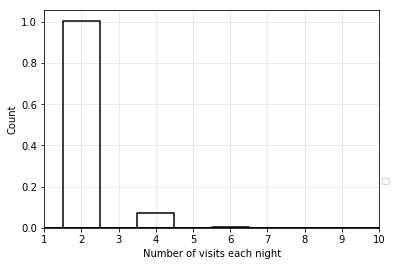

In [38]:
bu = [bundles['small']]# , bundles['normal']]
ph.setMetricBundles(bu)
colors = ['k', 'b', 'c', 'g', 'y', 'r', 'm']
for i, p in enumerate(bundles):
    bundles[p].setPlotDict({'color': colors[i % len(colors)]})
ph.plot(plotFunc=plots.SummaryHistogram(), plotDicts={'metricReduce': metrics.MeanMetric(),
        'yMin': 0, 'yMax':None, 'xMin':1, 'xMax': 10, 'legendloc': (1.01, .2)})
plt.title("")

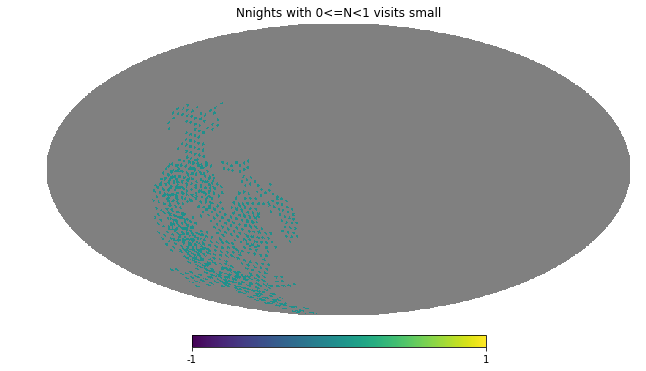

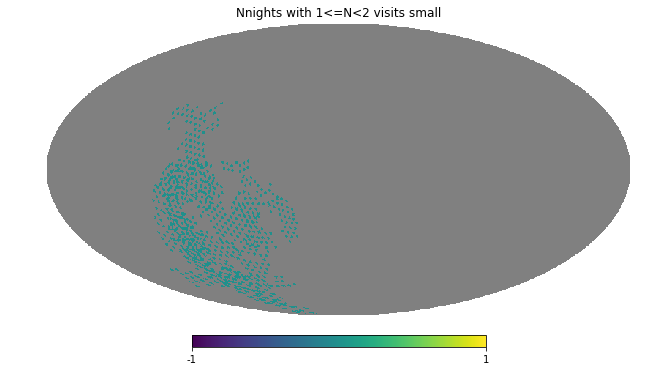

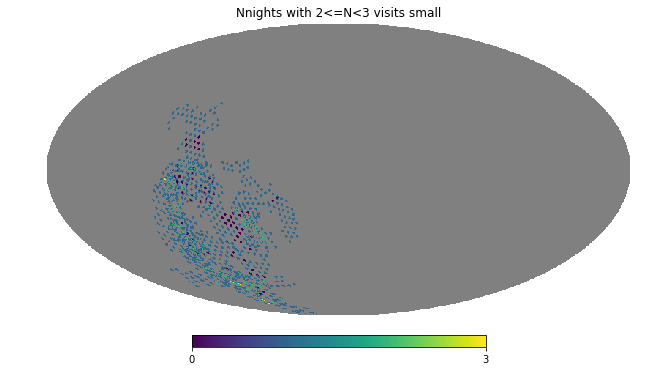

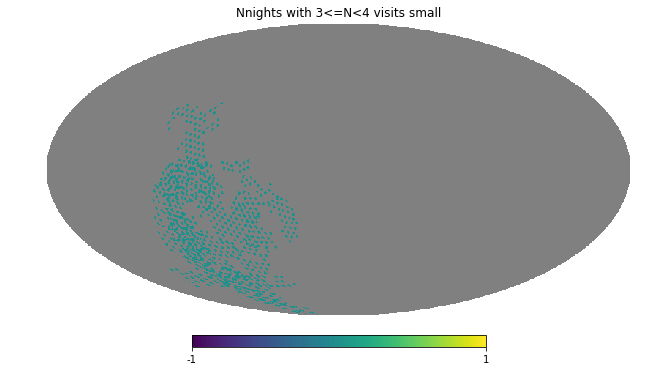

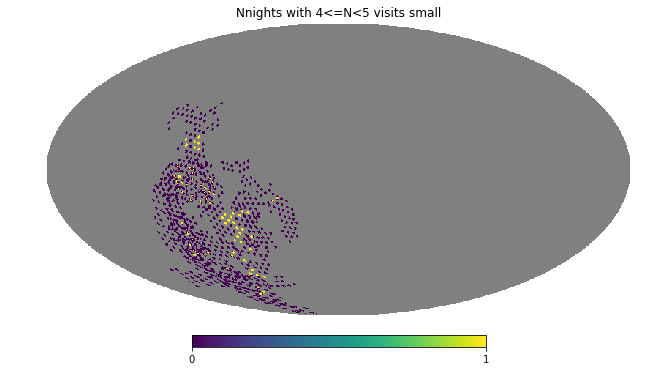

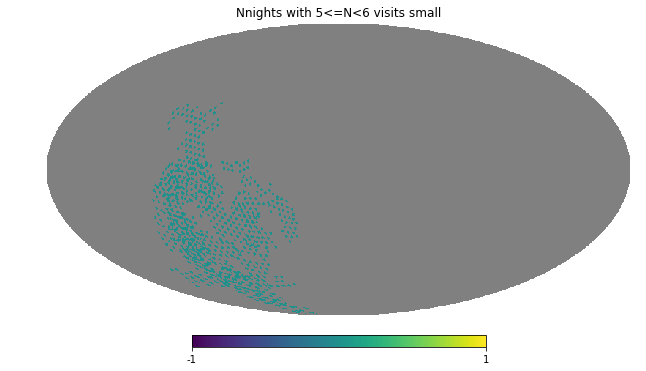

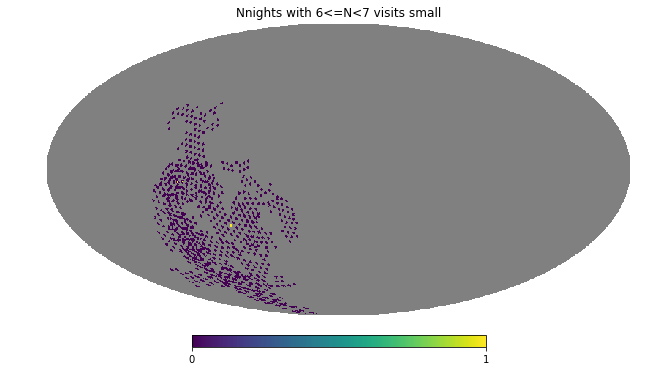

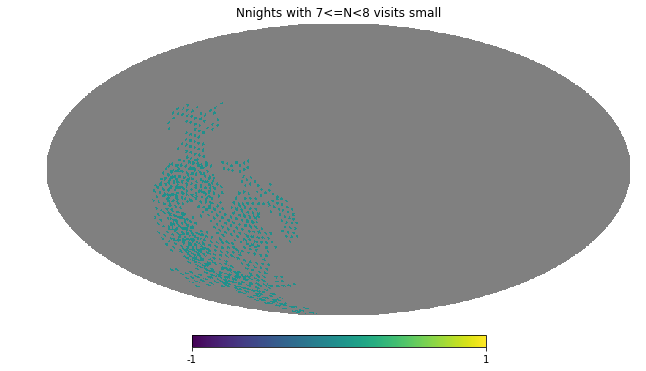

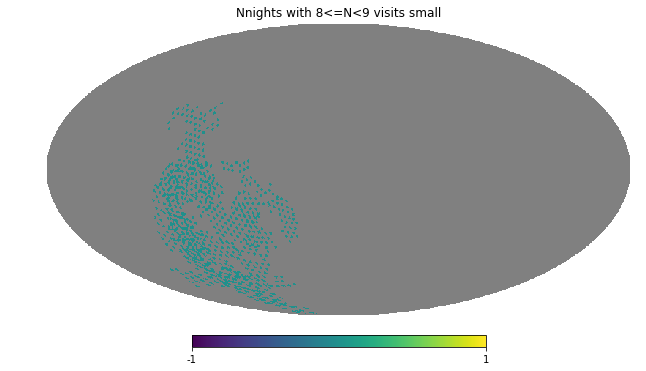

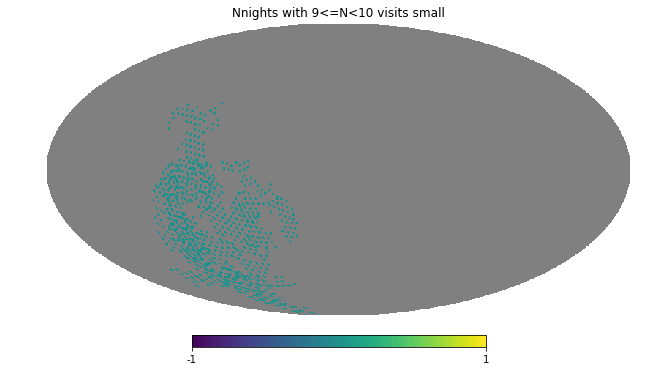

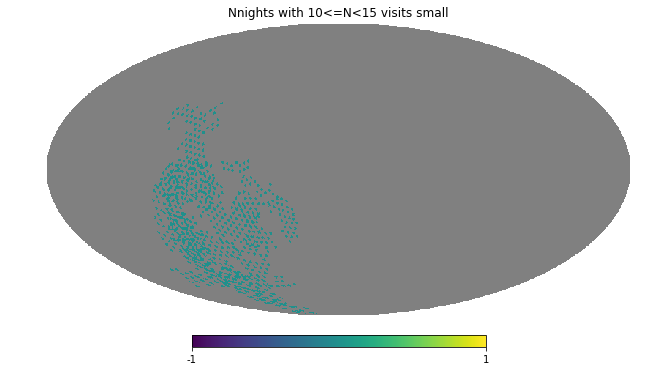

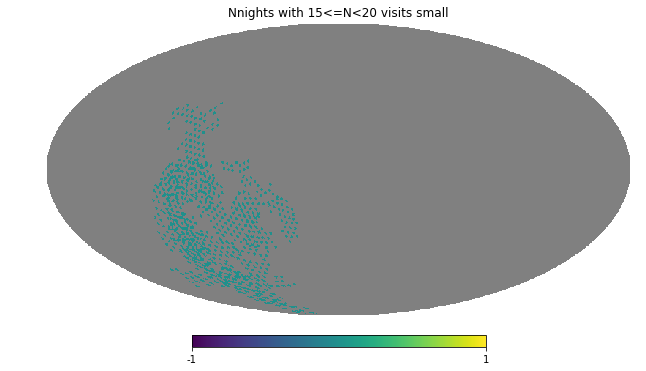

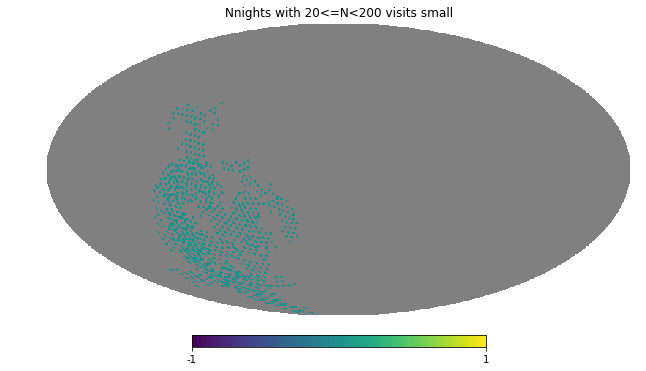

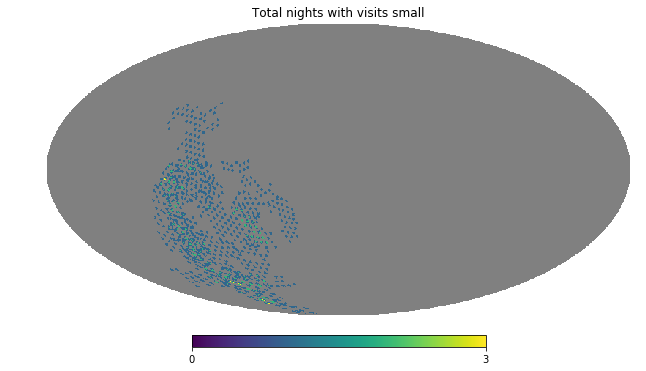

In [39]:
# These maps look good. Pointings are well separated, but no obvious gaps.
run = 'small'
t = np.zeros(len(bundles[run].metricValues))
for i in range(len(countbins)-1):
    v = subval_hist(bundles[run].metricValues, i)
    t += v
    hp.mollview(v, title=f'Nnights with {countbins[i]}<=N<{countbins[i+1]} visits {run}', min=0, max=None)
t = np.where(t<0, hp.UNSEEN, t)
hp.mollview(t, title=f'Total nights with visits {run}', min=0, max=None)

In [40]:
# Let's dive into those histograms a bit. Pulling out the sum of the '2 nights' bins, then the sum of the >2. 
v = subval_hist(bundles['small'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['small'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['small'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum())

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

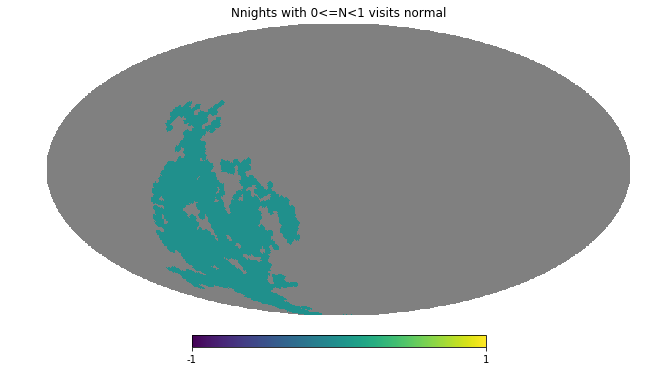

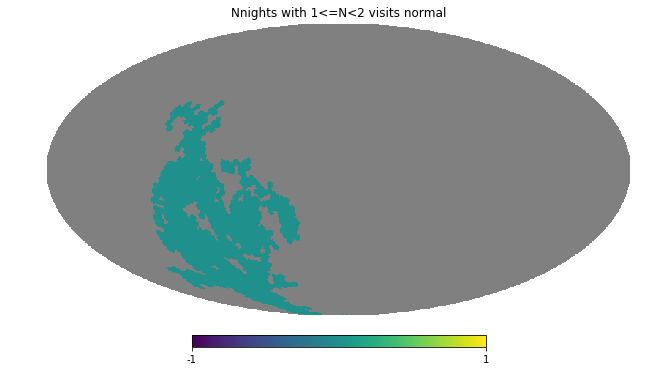

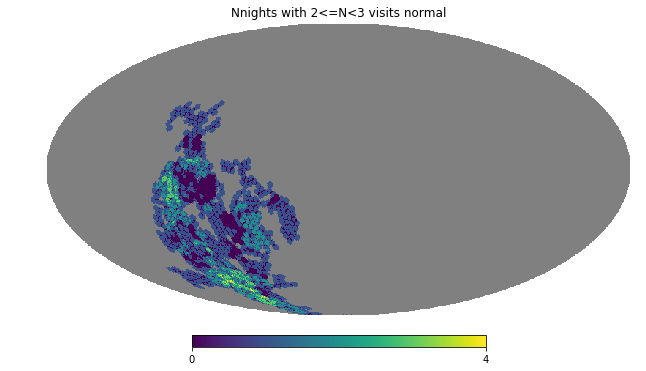

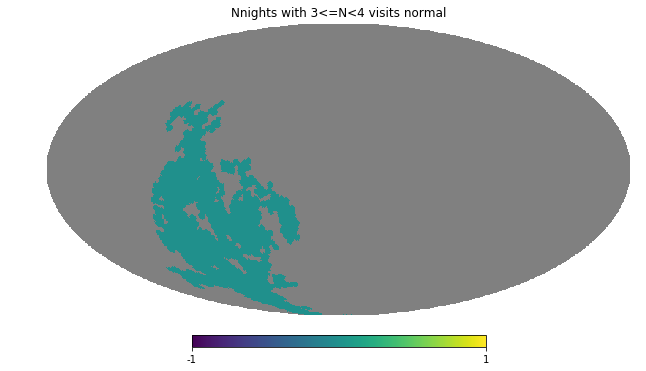

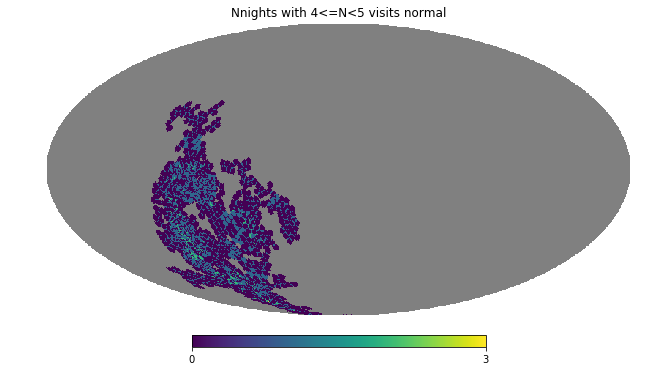

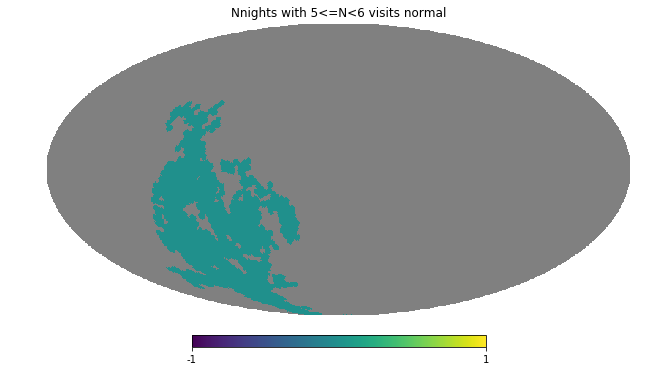

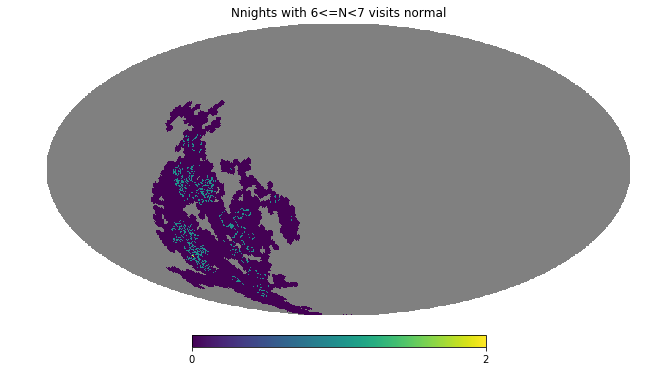

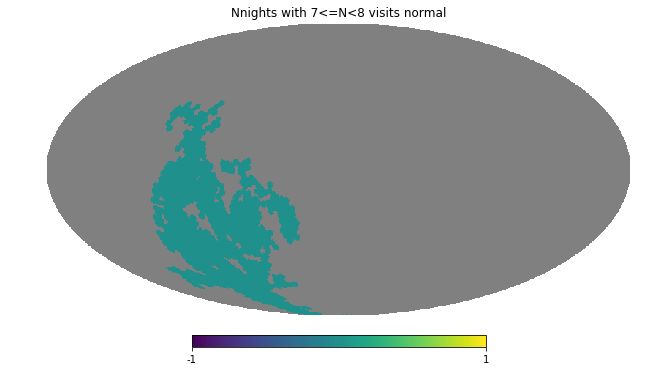

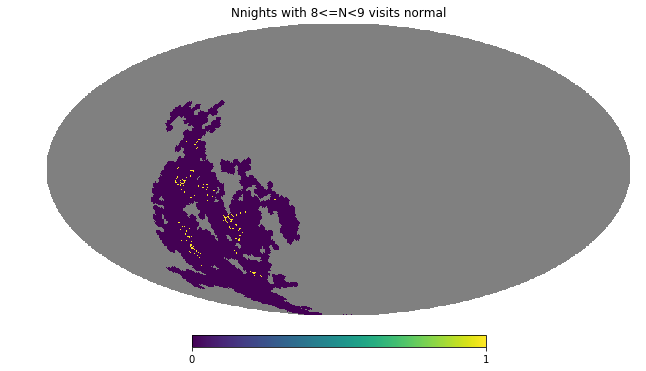

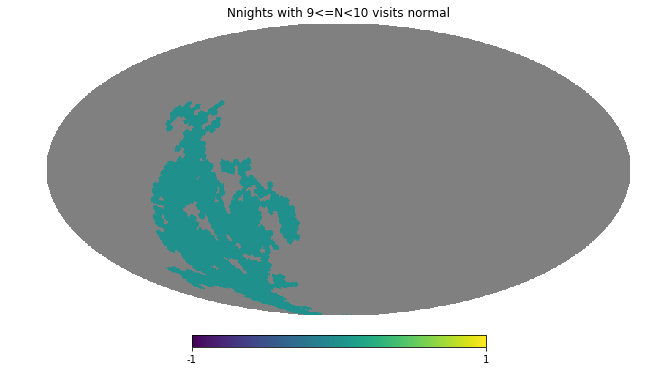

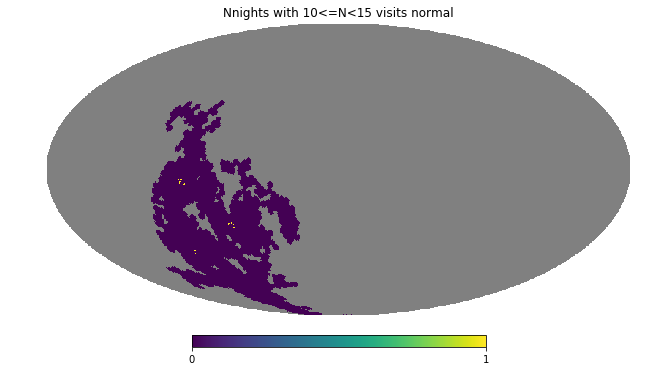

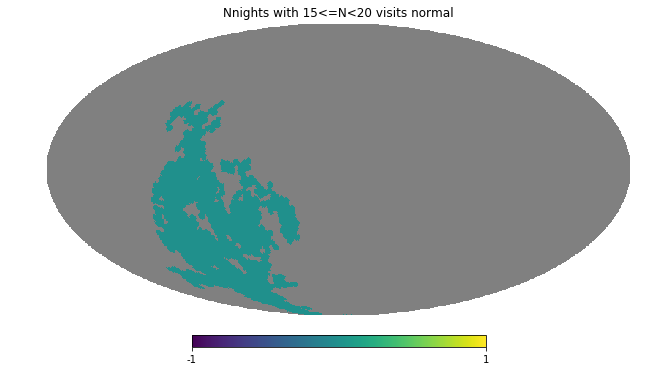

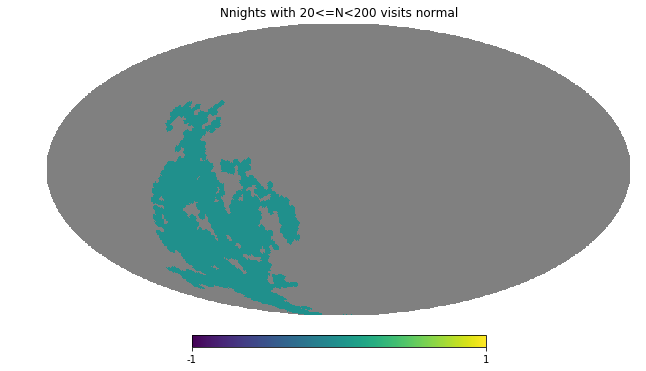

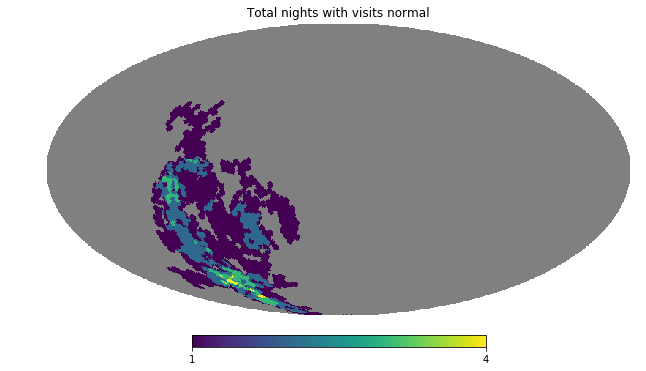

In [41]:
# And have a look at the same things for the 'normal' FOV radius.
run = 'normal'
t = np.zeros(len(bundles[run].metricValues))
for i in range(len(countbins)-1):
    v = subval_hist(bundles[run].metricValues, i)
    t += v
    hp.mollview(v, title=f'Nnights with {countbins[i]}<=N<{countbins[i+1]} visits {run}')
t = np.where(t<0, hp.UNSEEN, t)
hp.mollview(t, title=f'Total nights with visits {run}')

In [42]:
v = subval_hist(bundles['normal'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['normal'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['normal'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, a.sum(), b.sum(), b.sum()/a.sum())

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. ... 1. 1. 1.] 21032.0 8403.0 0.39953404336249526


## Thoughts

a = the healpix map of the points which received exactly two visits in a night (and the value at each point = how many nights received 2 visits). 
b = the healpix map of the points which received more than two visits in a night (and the number of nights with more than 2 visits, at each point). 
The length of a and the length of b tell you how many healpixels qualified in each case (2 visits/night or >2 visits/night). 
The *sum* of a and b tell you how many nights at each healpix point qualified .. and by taking the sum of each and then dividing them, we can find the ratio of how many points+nights got only 2 visits and how many got >2 visits.

By doing this for the 'small' slicer, which removes the effect of field overlaps, we can see how often fields were repeated in a night (i.e. scheduled for >2 visits).
With the 'normal' slicer, we can include both the scheduler revisiting fields >2 times AND the effect of field overlaps.

Looking at a single night, it looks like on nights with a high fraction of field revisits (such as night 89), we have a lower relative contribution from field overlaps. On a more typical night, such as night 50, we have a larger contribution from overlaps and smaller from the scheduler. (This matches what we see looking directly at the SQL outputs). 

Now to look at the whole sky/whole survey.

In [43]:
bundles = {}

# Histogram the number of visits per night.
metric = metrics.NVisitsPerNightMetric(nightCol='night', bins=countbins,
                                       metricName="NVisitsPerNight")
slicerSmall = slicers.HealpixSlicer(nside=128, radius=0.75)
slicerNormal = slicers.HealpixSlicer(nside=128, radius=1.75)
plotDict = {'bins': countbins, 'xlabel': 'Number of visits each night'}
plotFunc = plots.SummaryHistogram()

constraint = 'note like "blob%"' # Can add a night to check that the 'small' slicer doesn't overlap

bundles['small'] = mb.MetricBundle(metric, slicerSmall, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='points', plotFuncs=[plotFunc])
bundles['normal'] = mb.MetricBundle(metric, slicerNormal, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='circles', plotFuncs=[plotFunc])
opsdb = db.OpsimDatabase(os.path.join(dbroot, runName+".db"))
g = mb.MetricBundleGroup({1: bundles['small'], 2: bundles['normal']}, opsdb, outDir=outDir, resultsDb=None)
g.runAll()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint note like "blob%" for columns ['night', 'fieldDec', 'fieldRA']
Found 1675167 visits
Running:  [1]
Completed metric generation.
Running:  [2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, '')

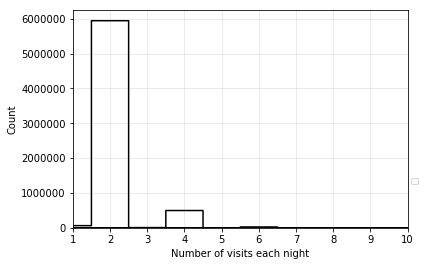

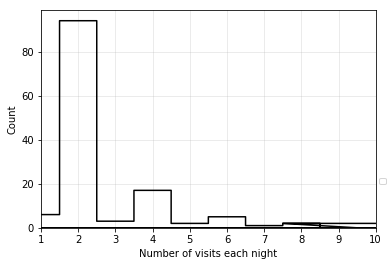

In [44]:
ph = plots.PlotHandler(outDir=outDir, savefig=False, thumbnail=False, figformat='png')
bu = [bundles['small']]#, bundles['normal']]
ph.setMetricBundles(bu)
colors = ['k', 'b', 'c', 'g', 'y', 'r', 'm']
for i, p in enumerate(bundles):
    bundles[p].setPlotDict({'color': colors[i % len(colors)]})
# First show with Sum - sum over sky
ph.plot(plotFunc=plots.SummaryHistogram(), plotDicts={'metricReduce': metrics.SumMetric(),
        'yMin': 0, 'yMax':None, 'xMin':1, 'xMax': 10, 'legendloc': (1.01, .2)})
plt.title("")
# And then show with Max - which will show peak nvisits/night at each bin (so more like highest single points on sky)
ph.plot(plotFunc=plots.SummaryHistogram(), plotDicts={'metricReduce': metrics.MaxMetric(),
        'yMin': 0, 'yMax':None, 'xMin':1, 'xMax': 10, 'legendloc': (1.01, .2)})
plt.title("")

In [45]:
v = subval_hist(bundles['small'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['small'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['small'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[ 1.  3.  1. ... 23. 22. 21.] [1. 1. 1. ... 1. 1. 1.] 128189 116503 0.9088377317866587 5943327.0 527485.0 0.08875247819950005


In [46]:
v = subval_hist(bundles['normal'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['normal'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['normal'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[  1.   2.   4. ... 117. 118. 111.] [1. 1. 2. ... 6. 4. 4.] 130307 129044 0.9903075045853255 18621519.0 8580578.0 0.4607882955198231


Over the entire survey, above -- we find about 9% of the fields are rescheduled for more than 2 visits, but about 46% of the time a field gets more than 2 visits in a night -- the 37% or so boost is due to field overlap. Obviously, the effect of field overlap will also vary depending on how 'blobs' are scheduled on the sky -- more contiguous fields will mean more overlap effect.

This was for 'blobs' only (the visits scheduled for pairs, which make up the bulk of the survey). But we can add other modes of operation too (but exclude DD, because they will be odd and have a different dithering scheme).

In [47]:
# Check for all visits in a night, not just blobs. I think this should be very similar though.
# But exclude DDFs because their dithering is different and could throw things off.
# We can also simplify the countbins now that we have explored the basics above. 
# And why not throw in an extra slicer, with a slightly reduced radius, to check scaleback of overlap.

bundles = {}
countbins = np.array([0, 1, 2, 3, 200], int)

# Histogram the number of visits per night.
metric = metrics.NVisitsPerNightMetric(nightCol='night', bins=countbins,
                                       metricName="NVisitsPerNight")
slicerSmall = slicers.HealpixSlicer(nside=64, radius=0.75)  # Should contain only the center pointings
slicerShrunk = slicers.HealpixSlicer(nside=64, radius=1.5)  # A slightly reduced FOV .. chip edges?
slicerNormal = slicers.HealpixSlicer(nside=64, radius=1.75) # Full inscribed FOV
plotDict = {'bins': countbins, 'xlabel': 'Number of visits each night'}
plotFunc = plots.SummaryHistogram()

constraint = 'note not like "DD%"'

bundles['small'] = mb.MetricBundle(metric, slicerSmall, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='points', plotFuncs=[plotFunc])
bundles['shrunk'] = mb.MetricBundle(metric, slicerShrunk, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='shrunkcircles', plotFuncs=[plotFunc])
bundles['normal'] = mb.MetricBundle(metric, slicerNormal, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='circles', plotFuncs=[plotFunc])
opsdb = db.OpsimDatabase(os.path.join(dbroot, runName+".db"))
g = mb.MetricBundleGroup({1: bundles['small'], 2:bundles['shrunk'], 3: bundles['normal']}, opsdb, 
                         outDir=outDir, resultsDb=None)
g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint note not like "DD%" for columns ['night', 'fieldDec', 'fieldRA']
Found 1952027 visits
Running:  [1]
Completed metric generation.
Running:  [2]
Completed metric generation.
Running:  [3]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [48]:
v = subval_hist(bundles['small'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['small'].metricValues, 3)  # this bin should have all of the >2 ..
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[ 2.  1. 10. ... 25. 21. 24.] [2. 1. 1. ... 1. 1. 3.] 32025 29345 0.9163153786104605 1527834.0 151059.0 0.09887134335274644


In [49]:
v = subval_hist(bundles['shrunk'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['shrunk'].metricValues, 3)  # this bin should have all of the >2 ..
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[ 1.  4.  9. ... 93. 92. 83.] [1. 3. 3. ... 1. 1. 3.] 32419 32120 0.9907770134797496 4740064.0 1308906.0 0.2761367779000452


In [50]:
v = subval_hist(bundles['normal'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['normal'].metricValues, 3)  # this bin should have all of the >2 ..
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[  4.  10.   3. ... 117. 113. 112.] [1. 2. 1. ... 2. 7. 5.] 32591 32283 0.990549538216072 4860790.0 2434520.0 0.5008486274864785


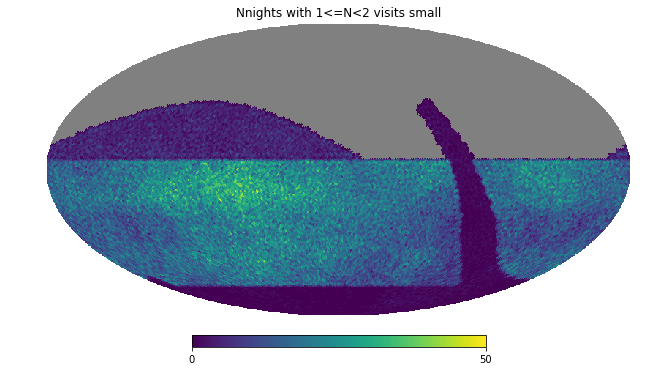

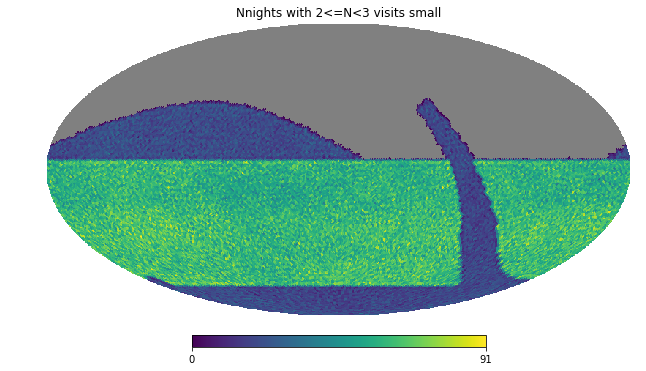

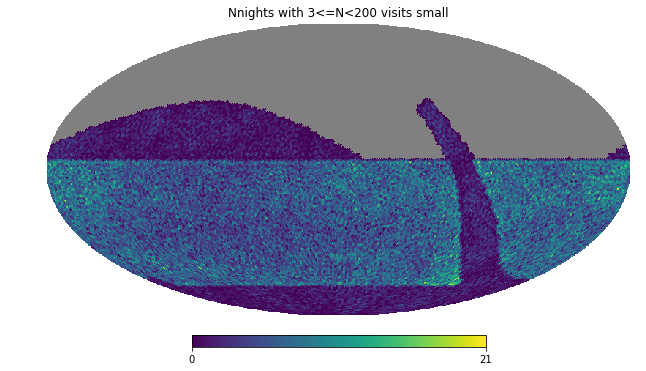

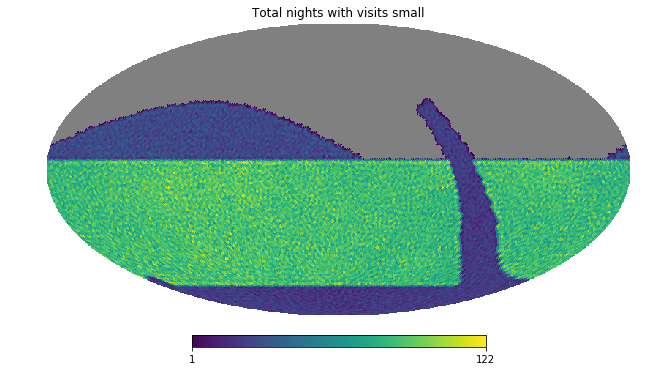

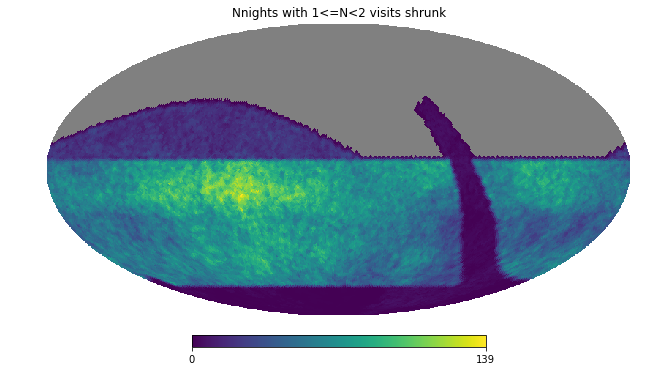

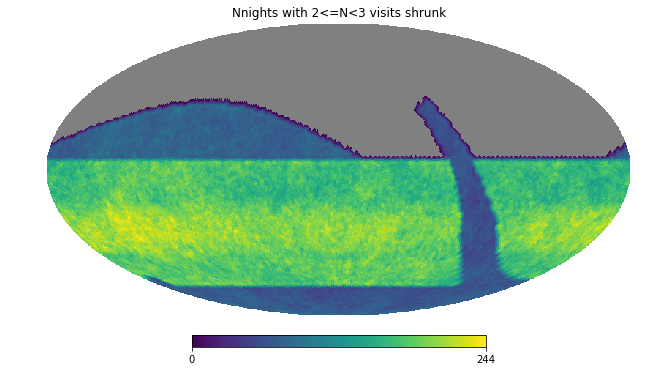

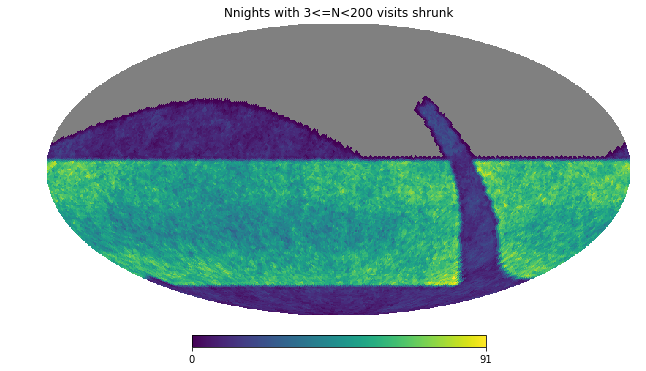

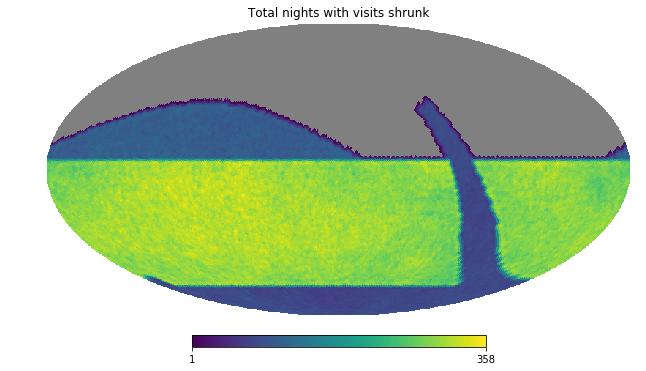

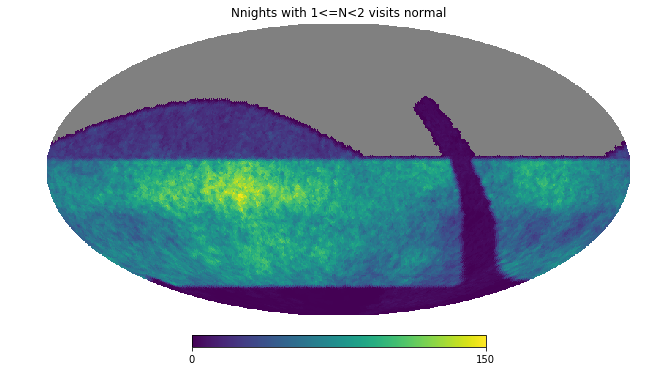

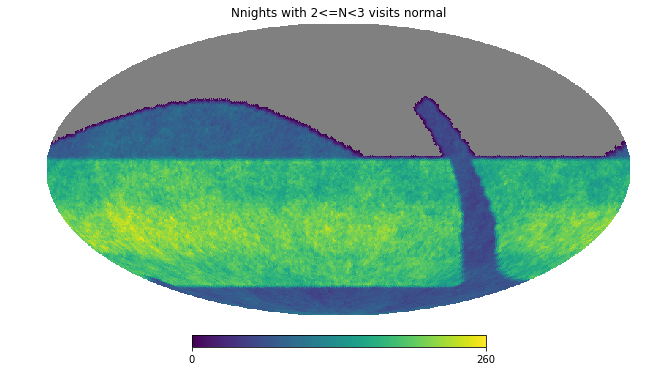

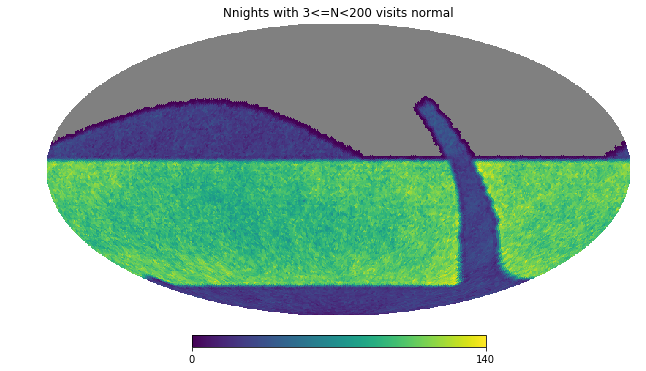

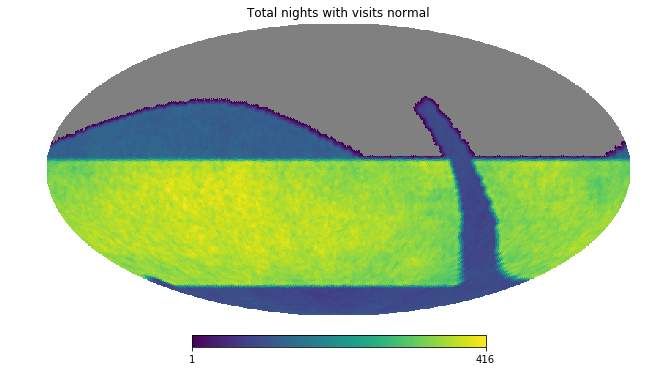

In [52]:
for run in ['small', 'shrunk', 'normal']:
    t = np.zeros(len(bundles[run].metricValues))
    for i in range(1, len(countbins)-1):
        v = subval_hist(bundles[run].metricValues, i)
        t += v
        hp.mollview(v, title=f'Nnights with {countbins[i]}<=N<{countbins[i+1]} visits {run}')
    t = np.where(t<0, hp.UNSEEN, t)
    hp.mollview(t, title=f'Total nights with visits {run}')

## Conclusion

Overall, it looks like the scheduler is currently occasionally (8-10% of the time) going back to a field previously visited earlier in the night. Much more often (37-40% of the time), a part of the sky is re-observed more than twice due to field overlaps and how the scheduler is scheduling within blobs. Scheduling for nearby parts of the sky, in contiguous areas, is desireable in general -- it will reduce slew time and make it easier to recover moving objects. Frequent revisits to the same field provides the opportunity for increased cadence on variables and transients, but for more slowly varying objects, it does likely come at some cost of reduced frequency of coverage on a night-to-night revisit scale. One thing to keep in mind is that this analysis is approximate; it does not include the precise camera footprint, but rather an inscribed circle. 

In [59]:
# effect in a different run like the rolling cadence? 

# Check for all visits in a night, not just blobs. I think this should be very similar though.
# But exclude DDFs because their dithering is different and could throw things off.
# We can also simplify the countbins now that we have explored the basics above. 
# And why not throw in an extra slicer, with a slightly reduced radius, to check scaleback of overlap.

bundles = {}
countbins = np.array([0, 1, 2, 3, 200], int)

dbroot = '/astro/store/pogo4/opsim/fbs_db/fbs_1.7/rolling'
runName = 'rolling_scale0.8_nslice3_v1.7_10yrs'

# Histogram the number of visits per night.
metric = metrics.NVisitsPerNightMetric(nightCol='night', bins=countbins,
                                       metricName="NVisitsPerNight")
slicerSmall = slicers.HealpixSlicer(nside=64, radius=0.75)  # Should contain only the center pointings
slicerShrunk = slicers.HealpixSlicer(nside=64, radius=1.5)  # A slightly reduced FOV .. chip edges?
slicerNormal = slicers.HealpixSlicer(nside=64, radius=1.75) # Full inscribed FOV
plotDict = {'bins': countbins, 'xlabel': 'Number of visits each night'}
plotFunc = plots.SummaryHistogram()

constraint = 'note not like "DD%"'

bundles['small'] = mb.MetricBundle(metric, slicerSmall, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='points', plotFuncs=[plotFunc])
bundles['shrunk'] = mb.MetricBundle(metric, slicerShrunk, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='shrunkcircles', plotFuncs=[plotFunc])
bundles['normal'] = mb.MetricBundle(metric, slicerNormal, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='circles', plotFuncs=[plotFunc])
opsdb = db.OpsimDatabase(os.path.join(dbroot, runName+".db"))
g = mb.MetricBundleGroup({1: bundles['small'], 2:bundles['shrunk'], 3: bundles['normal']}, opsdb, 
                         outDir=outDir, resultsDb=None)
g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint note not like "DD%" for columns ['night', 'fieldDec', 'fieldRA']
Found 1954138 visits
Running:  [1]
Completed metric generation.
Running:  [2]
Completed metric generation.
Running:  [3]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [60]:
for r in ['small', 'shrunk', 'normal']:
    v = subval_hist(bundles[r].metricValues, 2)
    a = v[np.where(v>0)]
    v = subval_hist(bundles[r].metricValues, 3)  # this bin should have all of the >2 ..
    b = v[np.where(v>0)]
    print(r, a.sum(), b.sum(), b.sum()/a.sum() )

small 1381921.0 237756.0 0.17204746146849204
shrunk 3908276.0 1722053.0 0.4406170393288499
normal 3909545.0 2794509.0 0.7147913631893226
